<a href="https://colab.research.google.com/github/PierreSylvain/allocine-sentiment/blob/main/CamemBERT_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de sentiments avec CamemBERT
Ce projet vise à classifier des sentiments positifs ou négatif avec le modèle CamemBERT. Les données d'entrainement, de test et de validations sont issues de Hugging Face. Ce sont les donénes extraite des commentaires du site allocine.fr.

Nous avons utilisé Pytorch pour l'entrainement du modèle.


# Citations

```
@inproceedings{martin2020camembert,
  title={CamemBERT: a Tasty French Language Model},
  author={Martin, Louis and Muller, Benjamin and Su{\'a}rez, Pedro Javier Ortiz and Dupont, Yoann and Romary, Laurent and de la Clergerie, {\'E}ric Villemonte and Seddah, Djam{\'e} and Sagot, Beno{\^\i}t},
  booktitle={Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics},
  year={2020}
}
```

>Théophile Blard, French sentiment analysis with BERT, (2020), GitHub repository, https://github.com/TheophileBlard/french-sentiment-analysis-with-bert




# Chargement des bibliothèques
Dans ce projet nous utilison PyTorch

## Installation des packages pour CamemBERT

In [ ]:
!pip install transformers>=4.0
!pip install datasets
!pip install sentencepiece

## Bibliothèques

In [36]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score

import seaborn
from sklearn import metrics

from tqdm.notebook import tqdm # Barre de progression

In [15]:
from transformers import CamembertTokenizer
from transformers import CamembertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

# Fonctions

In [17]:
def f1_score_func(preds, labels):
  """Calcul du F1 score avec plkusiers labels"""
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

In [20]:
def accuracy_per_class(preds, labels):
  """Calcul de la précision pour chaque classe"""
  label_dict_inverted = {
      0: 'Negative',
      1: 'Positive'
  }
    
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
    
  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat ==label]
      print(f'Class: {label_dict_inverted[label]}')
      print(f'Accuracy: {(len(y_preds[y_preds==label])/len(y_true))*100:.2f}%\n')


In [26]:
def evaluate(dataloader_val):
  """Evaluation du modèle"""
  model.eval()
    
  loss_val_total = 0
  predictions, true_vals = [], []
    
  for batch in dataloader_val:
        
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
               }
        
      with torch.no_grad():        
          outputs = model(**inputs)
            
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
    
  loss_val_avg = loss_val_total/len(dataloader_val) 
    
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
            
  return loss_val_avg, predictions, true_vals

# Chargement des données
Le dataset provient de hugging face (https://huggingface.co/datasets/allocine)

Le jeu de données Allociné est un jeu de données en langue française pour l'analyse des sentiments. Les textes sont des critiques de films écrits entre 2006 et 2020 par des membres de la communauté Allociné.fr pour différents films. Il contient 100k critiques positives et 100k négatives divisées en train (160k), validation (20k), et test (20k).



> Théophile Blard, French sentiment analysis with BERT, (2020), GitHub repository, https://github.com/TheophileBlard/french-sentiment-analysis-with-bert


In [4]:
from datasets import load_dataset
train_ds, val_ds, test_ds = load_dataset(
    'allocine', 
    split=['train', 'validation', 'test']
)

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/866 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset allocine_dataset downloaded and prepared to /root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Préparation des données

## Tokenisation
Encodage des données avec la version 'camembert-base'

|Modèle|nb params|Arch.|Données d'entrainement|
|-----|------|------|-------------|
|camembert-base|110M|Base|OSCAR (138 GB of text)|

> CamemBERT a été entrainé et évalué par Louis Martin*, Benjamin Muller*, Pedro Javier Ortiz Suárez*, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah et Benoît Sagot.

In [5]:
tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

### Tokenisation par lots

In [6]:
# Train
encoded_data_train = tokenizer.batch_encode_plus(
    train_ds['review'],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [7]:
# Validation
encoded_data_val = tokenizer.batch_encode_plus(
    val_ds['review'],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Création des dataset

In [8]:
# Train
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_ds['label'])

dataset_train = TensorDataset(
    input_ids_train, 
    attention_masks_train, 
    labels_train)


In [9]:
# Validation
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_ds['label'])

dataset_val = TensorDataset(
    input_ids_val, 
    attention_masks_val, 
    labels_val)


## Chargeur de données
On utilise des indices aléatoires pour que le modèle n'apprenne pas par rapport à l'ordre des données

In [12]:
# Train
batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

In [13]:
# Validation
batch_size = 32

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

# Modèle
Comme c'est un modèle de classification on utilise le modèle qqui est approprié.
Seulement deux labels : positif ou négatif

Nous n'avons pas besoin d'avoir le retour des tenseurs d'attentions, ni e toutes les couches d'attention.

Tout comme les couches cachées


In [14]:
model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base', 
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

## Optimizer

Utilisation de AdamW qui se veut plus performant que Adam

> AdamW est une méthode d'optimisation stochastique qui modifie l'implémentation typique de la décroissance du poids dans Adam pour combattre les problèmes de convergence connus d'Adam en découplant la décroissance du poids des mises à jour du gradient.

In [21]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, # 2e-5 > 5e-5
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [26]:
epochs = 6
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

# Initialisation

In [23]:
# Initialisation des nombres aléatoires à 17 comme Charente-Martime

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [24]:
# Utilisation de GPU (recommendé) ou CPU (vraiment très long)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


# Entrainement du modèle
Cette opération est très longue, il faut compte 1 heure par époque avec un GPU

Chaque époque est enregistrée dans un fichier sur Google Drive

In [ ]:
def train_model():
  """Entrainement du modèle"""
  for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(
        dataloader_train, 
        desc=f'Epoch {epoch}',
        leave=False,
        disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'./drive/MyDrive/Models/CamemBERT_epoch_{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weight): {val_f1}')
  

# Test du modèle

In [27]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False).to("cuda")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

## Chargement du modèle

In [28]:
model.load_state_dict(
    torch.load('./drive/MyDrive/Models/CamemBERT_epoch_6.model',
              map_location=torch.device('cuda')))

<All keys matched successfully>

## Tokenization des données

In [29]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_ds['review'],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_ds['label'])

dataset_test = TensorDataset(
    input_ids_test, 
    attention_masks_test,  
    labels_test)


In [31]:
batch_size = 32

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

## Evaluation de la prédiction

In [32]:
_, prediction, true_values = evaluate(dataloader_test)

In [33]:
accuracy_per_class(prediction, true_values)

Class: Negative
Accuracy: 96.28%

Class: Positive
Accuracy: 97.90%



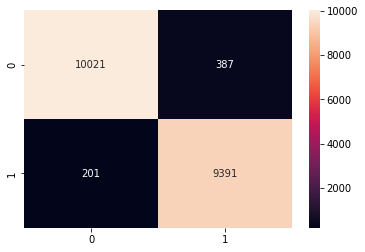

In [43]:
preds_flat = np.argmax(prediction, axis=1).flatten()
seaborn.heatmap(metrics.confusion_matrix(true_values, preds_flat),annot=True, fmt='g')

# Conclusion
Malgrès un bon score, il convient de regarder les mauvaises prédictions afin d'en déterminer la cause.
